In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# opening the dataset
dataset = pd.read_csv("../datasets/BitcoinHeistData.csv")
dataset

# extracting licit addresses (41413 rows)
licitAddresses = dataset.loc[dataset['label'] == 'white']

# extracting illicit addresses (2875284 rows)
IllicitAddresses = dataset.loc[dataset['label'] != 'white']

# removing an outlier
IllicitAddresses = IllicitAddresses.loc[IllicitAddresses['weight'] < 100]

#taking a random 100000 rows of the Illicit addresses (so as to not have very imbalanced data)
licit_subset = licitAddresses.sample(60000)

# merging the two classes
Full_Dataset = pd.concat([IllicitAddresses,licitAddresses])
DATA = Full_Dataset.reset_index()

# adding a new illicit column : 0 for licit addresses and 1 for illicit
Illicit = []*len(Full_Dataset)
for i in range(len(Full_Dataset)):
    if DATA['label'][i] == 'white' :
        Illicit.append(0)
    else :
        Illicit.append(1)
DATA['Illicit'] = Illicit

DATA = DATA.sample(frac=1)
DATA = DATA.reset_index()
DATA = DATA.dropna()

#droping unnecessary columns
features = DATA.drop(['level_0','index','address','year','day','label'], axis=1)
features


labels = np.array(features['Illicit'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('Illicit', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)
# Split the data into training and testing sets
# train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

print(features.shape)






(2916696, 6)


In [59]:
df_copy = dataset.copy()
chnk = df_copy[df_copy['label'] != 'white']
chnk = chnk.drop(['address','year','day','label'], axis=1)
row = chnk.iloc[0]
row = np.array(row)
row = row.reshape(1,-1)
row

array([[1.80000000e+01, 8.33333333e-03, 1.00000000e+00, 0.00000000e+00,
        2.00000000e+00, 1.00050000e+08]])

In [2]:
# Experiment #1

from sklearn.model_selection import RandomizedSearchCV

# Random search cross validation
# this is a method to determine the best hyperparameters to use with the model


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Train the model on training data
rf_random.fit(train_features, train_labels);

# printing the best hyperparameters 
rf_random.best_params_



# predictions = rf.predict(test_features)

# # some metrics to evaluate the model
# print(confusion_matrix(test_labels,predictions))
# print(classification_report(test_labels,predictions))
# print(accuracy_score(test_labels, predictions))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1577,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [7]:
from sklearn import metrics


# using the model with the best hyperparameters found before, to predict the test set
best_rf = rf_random.best_estimator_
pred = best_rf.predict(test_features)

score = metrics.f1_score(test_labels, pred)
print("F1 score :", score)
pscore = metrics.accuracy_score(test_labels, pred)
print("accuracy : ", pscore)

F1 score : 0.6043782441886707
accuracy :  0.8016575679574577


In [3]:
# Experiment #2

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from numpy import mean

# using a balanced random forest model, that makes up for how imbalanced the dataset is

# define model
model = BalancedRandomForestClassifier(n_estimators=1000,max_depth=20)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model using cross validation
scores = cross_val_score(model, features, labels, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.839


In [2]:
# Experiment #3

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


imbalanced_set = pd.concat([IllicitAddresses,licitAddresses])
imbalanced_set = imbalanced_set.reset_index()
imbalanced_set

Illicit = []*2916696
for i in range(2916696):
    if imbalanced_set['label'][i] == 'white' :
        Illicit.append(0)
    else :
        Illicit.append(1)
imbalanced_set['Illicit'] = Illicit

imbalanced_set = imbalanced_set.sample(frac=1)
imbalanced_set = imbalanced_set.reset_index()
imbalanced_set = imbalanced_set.dropna()

#droping unnecessary columns
features1 = imbalanced_set.drop(['level_0','index','address','year','day','label','Illicit'], axis=1)


labels1 = np.array(imbalanced_set['Illicit'])
# Remove the labels from the features
# Saving feature names for later use
# Convert to numpy array
features1 = np.array(features1)

# SMOTE + undersampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
features_bal, labels_bal = pipeline.fit_resample(features1, labels1)


In [15]:
dff = pd.DataFrame(labels_bal)
# 287k rows of class 1
dff.loc[dff[0] == 1]
# 575k rows of class 0
dff.loc[dff[0] == 0]

0
0       0
1       0
2       0
3       0
4       0
...    ..
575051  0
575052  0
575053  0
575054  0
575055  0

[575056 rows x 1 columns]

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

rff = RandomForestClassifier(n_estimators=1000,max_depth=20)
# define evaluation procedure
cvv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model using cross validation
scoress = cross_val_score(rff, features_bal, labels_bal, scoring='roc_auc', cv=cvv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scoress))

NameError: name 'mean' is not defined

In [11]:
from numpy import mean

# score using SMOTE
print('Mean ROC AUC: %.3f' % mean(scoress))

Mean ROC AUC: 0.964


Accuracy: 0.7349635180437784
F1 score: 0.7002007584207004
Recall: 0.7678571428571429
Precision: 0.6435014350143502

 clasification report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76      6054
           1       0.64      0.77      0.70      4088

    accuracy                           0.73     10142
   macro avg       0.73      0.74      0.73     10142
weighted avg       0.75      0.73      0.74     10142


 confussion matrix:
 [[4315 1739]
 [ 949 3139]]


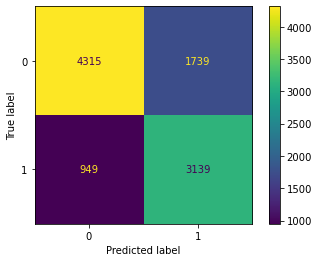

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier


rff = BalancedRandomForestClassifier(n_estimators=1500,max_depth=20)
train_features_bal, test_features_bal, train_labels_bal, test_labels_bal = train_test_split(features, labels, test_size = 0.1, random_state = 42)
rff.fit(train_features_bal, train_labels_bal)
preds = rff.predict(test_features_bal)

print ('Accuracy:', accuracy_score(test_labels_bal, preds))
print ('F1 score:', f1_score(test_labels_bal, preds))
print ('Recall:', recall_score(test_labels_bal, preds))
print ('Precision:', precision_score(test_labels_bal, preds))
print ('\n clasification report:\n', classification_report(test_labels_bal,preds))
print ('\n confussion matrix:\n',confusion_matrix(test_labels_bal, preds))

plot_confusion_matrix(rff, test_features_bal, test_labels_bal)
plt.show()    


In [5]:
# feature_imp = pd.Series(model.feature_importances_,index=['length','weight','count','looped','neighbors','income']).sort_values(ascending=False)
# feature_imp
# sns.barplot(x=feature_imp, y=feature_imp.index)
# # Add labels to your graph
# plt.xlabel('Feature Importance Score')
# plt.ylabel('Features')
# plt.title("Visualizing Important Features")
# plt.legend()
# plt.savefig("../imgs/Random forest features importance.jpg")
# plt.show()

In [24]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(test_labels_bal, preds)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.91866954 0.89645379]
recall: [0.95174996 0.83214818]
fscore: [0.93491721 0.86310487]
support: [57430 28829]


In [25]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print ('Accuracy:', accuracy_score(test_labels_bal, preds))
print ('F1 score:', f1_score(test_labels_bal, preds))
print ('Recall:', recall_score(test_labels_bal, preds))
print ('Precision:', precision_score(test_labels_bal, preds))
print ('\n clasification report:\n', classification_report(test_labels_bal,preds))
print ('\n confussion matrix:\n',confusion_matrix(test_labels_bal, preds))

Accuracy: 0.9117773217867121
F1 score: 0.863104874977514
Recall: 0.8321481841201568
Precision: 0.8964537947012443

 clasification report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93     57430
           1       0.90      0.83      0.86     28829

    accuracy                           0.91     86259
   macro avg       0.91      0.89      0.90     86259
weighted avg       0.91      0.91      0.91     86259


 confussion matrix:
 [[54659  2771]
 [ 4839 23990]]


In [26]:
rff_2 = RandomForestClassifier(n_estimators=1400,max_depth=20)
rff_2.fit(train_features_bal,train_labels_bal)
preds_2 = rff_2.predict(test_features_bal)
print ('Accuracy:', accuracy_score(test_labels_bal, preds_2))
print ('F1 score:', f1_score(test_labels_bal, preds_2))
print ('Recall:', recall_score(test_labels_bal, preds_2))
print ('Precision:', precision_score(test_labels_bal, preds_2))
print ('\n clasification report:\n', classification_report(test_labels_bal,preds_2))
print ('\n confussion matrix:\n',confusion_matrix(test_labels_bal, preds_2))

Accuracy: 0.9116150198819833
F1 score: 0.8628283555235696
Recall: 0.8317319365916265
Precision: 0.8963403237262159

 clasification report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93     57430
           1       0.90      0.83      0.86     28829

    accuracy                           0.91     86259
   macro avg       0.91      0.89      0.90     86259
weighted avg       0.91      0.91      0.91     86259


 confussion matrix:
 [[54657  2773]
 [ 4851 23978]]


In [27]:
import pickle 
pickle.dump(rff, open('RandomForest.pkl','wb'))


In [28]:
model = pickle.load(open('RandomForest.pkl','rb'))


In [32]:
tst = features_bal[20000].reshape(1, -1)
model.predict(tst)

array([0], dtype=int64)

In [10]:
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMClassifier
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

Lgb = LGBMClassifier(n_estimators=2500, silent=False, random_state =94, max_depth=20,num_leaves=37,objective='binary',metrics='recall')
fit_model = Lgb.fit(train_features_bal, train_labels_bal,eval_metric=recall_score)

test_predss = fit_model.predict(test_features_bal)

print ('Accuracy:', accuracy_score(test_labels_bal, test_predss))
print ('F1 score:', f1_score(test_labels_bal, test_predss))
print ('Recall:', recall_score(test_labels_bal, test_predss))
print ('Precision:', precision_score(test_labels_bal, test_predss))
print ('\n clasification report:\n', classification_report(test_labels_bal,test_predss))
print ('\n confussion matrix:\n',confusion_matrix(test_labels_bal, test_predss))


[LightGBM] [Info] Number of positive: 258699, number of negative: 517626
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 776325, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333235 -> initscore=-0.693588
[LightGBM] [Info] Start training from score -0.693588
Accuracy: 0.922454468519227
F1 score: 0.8804489642723097
Recall: 0.8543827396024836
Precision: 0.908155740727085

 clasification report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94     57430
           1       0.91      0.85      0.88     28829

    accuracy                           0.92     86259
   macro avg       0.92      0.91      0.91     86259
weighted avg       0.92      0.92      0.92     86259


 confussion matrix:
 [[54939  2491]

Best Threshold=0.209626, F-Score=0.89, recall=0.92, precision=0.81


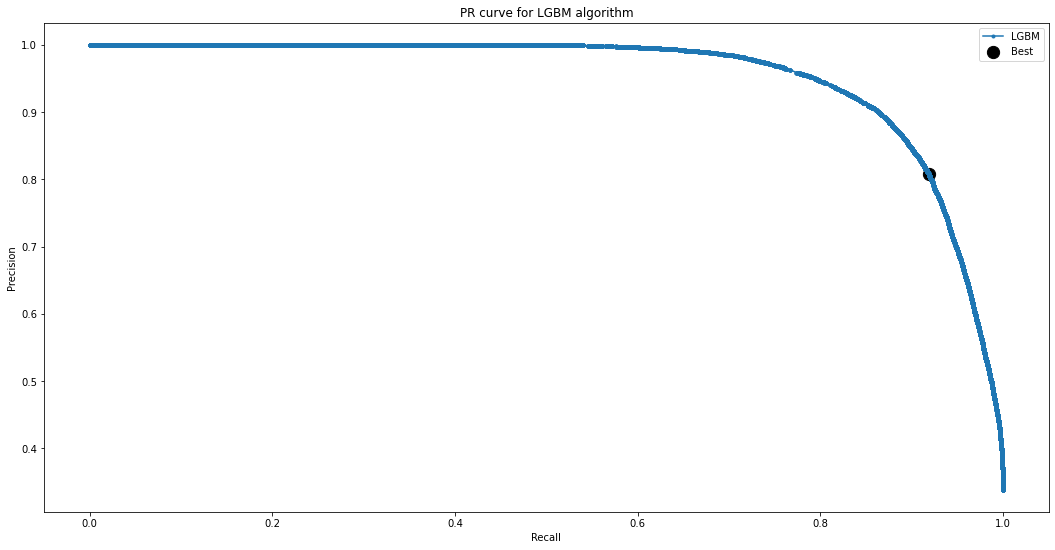

<Figure size 432x288 with 0 Axes>

In [21]:
from sklearn.metrics import precision_recall_curve, fbeta_score
from numpy import argmax

test_probas = fit_model.predict_proba(test_features_bal)
test_probas = test_probas[:, 1]
precision, recall, thresholds = precision_recall_curve(test_labels_bal, test_probas)

# convert to f score
fscore = (5 * precision * recall) / (4*precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.2f, recall=%.2f, precision=%.2f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))

plt.figure(figsize = (18,9))
plt.title("PR curve for LGBM algorithm")
plt.plot(recall, precision, marker='.', label='LGBM')
plt.scatter(recall[ix], precision[ix], marker='o',s=150, color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()
plt.savefig("../imgs/PR curve for LGBM algorithm.jpg")


In [3]:
train_features_bal1, test_features_bal1, train_labels_bal1, test_labels_bal1 = train_test_split(features, labels, test_size = 0.1, random_state = 42)
over1 = SMOTE(sampling_strategy=0.1)
under1 = RandomUnderSampler(sampling_strategy=0.5)
steps1 = [('o', over1), ('u', under1)]
pipeline1 = Pipeline(steps=steps1)
# transform the dataset
features_bal_1, labels_bal_1 = pipeline1.fit_resample(train_features_bal1, train_labels_bal1)

dff1 = pd.DataFrame(labels_bal_1)
# 287k rows of class 1
print("class 1 count :",len(dff1.loc[dff1[0] == 1].index))
# 575k rows of class 0
print("class 2 count :",len(dff1.loc[dff1[0] == 0].index))

NameError: name 'RandomUnderSampler' is not defined

In [40]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

train_features_bal1, test_features_bal1, train_labels_bal1, test_labels_bal1 = train_test_split(features, labels, test_size = 0.1, random_state = 42)
over1 = SMOTE(sampling_strategy=0.03)
under1 = RandomUnderSampler(sampling_strategy=0.97)
steps1 = [('o', over1), ('u', under1)]
pipeline1 = Pipeline(steps=steps1)
# transform the dataset
features_bal_1, labels_bal_1 = pipeline1.fit_resample(train_features_bal1, train_labels_bal1)

dff1 = pd.DataFrame(labels_bal_1)
# 287k rows of class 1
print("class 1 count :",len(dff1.loc[dff1[0] == 1].index))
# 575k rows of class 0
print("class 2 count :",len(dff1.loc[dff1[0] == 0].index))

class 1 count : 77631
class 2 count : 80031


In [14]:
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

Lgb1 = LGBMClassifier(n_estimators=2500, silent=False, random_state =94, max_depth=20,num_leaves=35,objective='binary',metrics='recall')
fit_model1 = Lgb1.fit(features_bal_1, labels_bal_1,eval_metric=recall_score)

test_predss1 = fit_model1.predict(test_features_bal1)

print ('Accuracy:', accuracy_score(test_labels_bal1, test_predss1))
print ('F1 score:', f1_score(test_labels_bal1, test_predss1))
print ('Recall:', recall_score(test_labels_bal1, test_predss1))
print ('Precision:', precision_score(test_labels_bal1, test_predss1))
print ('\n clasification report:\n', classification_report(test_labels_bal1,test_predss1))
print ('\n confussion matrix:\n',confusion_matrix(test_labels_bal1, test_predss1))

[LightGBM] [Info] Number of positive: 72097, number of negative: 72097
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 144194, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.7866084664799868
F1 score: 0.6725641349677746
Recall: 0.6277423920736023
Precision: 0.7242787152966794

 clasification report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      7903
           1       0.72      0.63      0.67      4239

    accuracy                           0.79     12142
   macro avg       0.77      0.75      0.76     12142
weighted avg       0.78      0.79      0.78     12142


 confussion matrix:
 [[689

In [6]:
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

train_features_bal1, test_features_bal1, train_labels_bal1, test_labels_bal1 = train_test_split(features, labels, test_size = 0.1, random_state = 42)
Lgb1 = LGBMClassifier(n_estimators=2500, silent=False, random_state =94, max_depth=20,num_leaves=35,objective='binary',metrics='recall')
fit_model1 = Lgb1.fit(train_features_bal1, train_labels_bal1,eval_metric=recall_score)

test_predss1 = fit_model1.predict(test_features_bal1)

print ('Accuracy:', accuracy_score(test_labels_bal1, test_predss1))
print ('F1 score:', f1_score(test_labels_bal1, test_predss1))
print ('Recall:', recall_score(test_labels_bal1, test_predss1))
print ('Precision:', precision_score(test_labels_bal1, test_predss1))
print ('\n clasification report:\n', classification_report(test_labels_bal1,test_predss1))
print ('\n confussion matrix:\n',confusion_matrix(test_labels_bal1, test_predss1))

[LightGBM] [Info] Number of positive: 37272, number of negative: 36898
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1154
[LightGBM] [Info] Number of data points in the train set: 74170, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502521 -> initscore=0.010085
[LightGBM] [Info] Start training from score 0.010085
Accuracy: 0.7572191215724339
F1 score: 0.7537836840162421
Recall: 0.7398550724637681
Precision: 0.7682468021068473

 clasification report:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76      4102
           1       0.77      0.74      0.75      4140

    accuracy                           0.76      8242
   macro avg       0.76      0.76      0.76      8242
weighted avg       0.76      0.76      0.76      8242


 confussion matrix:
 [[3178  924]
 [10

In [2]:
# decision tree evaluated on imbalanced dataset with SMOTE oversampling
from numpy import mean
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset
# define model
Lgb = LGBMClassifier(n_estimators=2500, silent=False, random_state =94, max_depth=20,num_leaves=35,objective='binary',metrics='recall')

# define pipeline
over = SMOTE(sampling_strategy=0.02)
under = RandomUnderSampler(sampling_strategy=0.98)
steps = [('over', over), ('under',under), ('model', Lgb)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
scores = cross_validate(pipeline, features , labels, scoring='recall', cv=cv, n_jobs=-1)
print(scores)

{'fit_time': array([70.65692449, 58.46491623, 55.82809234, 59.45091867, 58.40591669,
       52.83295751, 56.44696879, 62.06384683, 28.55061555, 24.72988844]), 'score_time': array([458.35956669, 444.12904453, 473.15892196, 469.4430604 ,
       467.69977593, 455.88273525, 461.87335825, 460.66560102,
        57.54410386,  56.7162497 ]), 'test_score': array([0.65950254, 0.65515576, 0.66312485, 0.67471625, 0.67358764,
       0.66296475, 0.66916204, 0.65732915, 0.68171939, 0.68075344])}


In [46]:
scores

{'fit_time': array([47.18119788, 47.04425907, 45.62919307, 47.63621426, 46.92321563,
        45.38318992, 46.8301959 , 45.34121776, 38.96195221, 37.99599934,
        37.8217392 , 45.34586668, 44.2808938 , 42.41493392, 40.68693924,
        46.30613351, 41.64977145, 38.31296921, 37.67192197, 42.75898218,
        45.32003021, 41.42995858, 45.20391393, 45.73387718, 39.45991445,
        40.24091268, 40.5869236 , 38.8598032 , 40.72385931, 37.1460309 ]),
 'score_time': array([305.84952807, 207.75364494, 350.16654944, 378.07443237,
        271.26357436, 375.60350418, 344.72449136, 361.14252067,
        411.59334564, 421.32431412, 421.2093451 , 419.54437757,
        430.82432008, 412.56881595, 414.58932543, 409.59807825,
        422.63833737, 421.99029016, 411.7494173 , 407.00478888,
        413.31827044, 419.91131926, 419.35574889, 418.3322947 ,
        328.92638373, 280.51438904, 242.28753614, 207.36678958,
        201.96057343, 195.28813243]),
 'test_score': array([0.60178701, 0.62110601, 0.